In [2]:
import pandas as pd
import numpy as np 
import tqdm
import os
import matplotlib.pyplot as plt
import rasterio
import re
import folium
from branca.colormap import LinearColormap

import seaborn as sns

import random

import torch
import torch.nn as nn
from scipy.stats import genextreme, gaussian_kde
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Rectangle
path = ''+'PDM_Super-Resolution-Precipitation-Extremes'

This file presents the exploration results.

# 1- Feature Selection

--> Model from 12 km to 2 km with the present data

First, this section reads the files in the 'loss12_finale' folder. There is one file per iteration (with a total number of features: number in the location parameter + number in the scale parameter), and in each file, a line corresponds to a model tested with an additional feature compared to the model selected in the previous iteration. It reports the various metrics of each model calculated on the validation set (blue zone) of the space.

## Pareto Front 

In [3]:
os.chdir(path + 'output/loss12_finale')
liste_df = []
for name_file in os.listdir():
    if name_file[0] == 'l':
        df = pd.read_csv(name_file)
        df['nbr_param'] = int(re.findall(r'\d+', name_file[10:])[0])
        liste_df.append(df)
df = pd.concat(liste_df, ignore_index = True)

# Creation of the pareto front 
pareto_front = df.groupby('nbr_param')['distW'].min().reset_index()
pf = pareto_front.distW
for i in range(len( pf)-1):
    if  pf[i] <  pf[i+1]:
         pf[i+1] =  pf[i]

(0.00115, 0.0018)

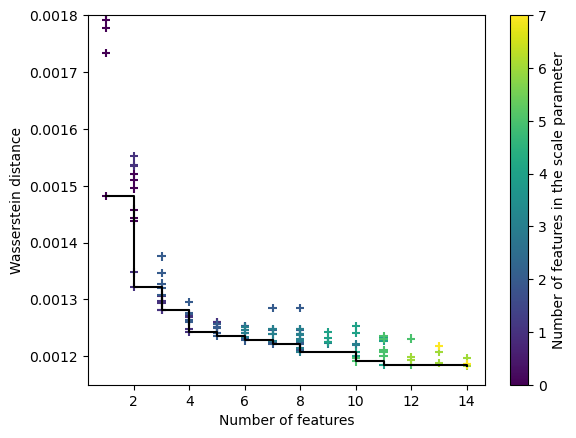

In [170]:
plt.scatter(df.nbr_param, df.distW, marker = '+', c=df.param_scale, cmap='viridis')
plt.xlabel('Number of features')
plt.ylabel('Wasserstein distance')

# Tracer la ligne noire de la frontière de Pareto
plt.step(pareto_front.nbr_param, pareto_front.distW, where='post', color='black')
plt.colorbar(label='Number of features in the scale parameter')
plt.ylim(0.00115, 0.0018)

/var/folders/xr/8f3zfp192yj0kkf49714c4zw0000gn/T/ipykernel_2368/2123569827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pf[i+1] =  pf[i]


(3.5, 9.0)

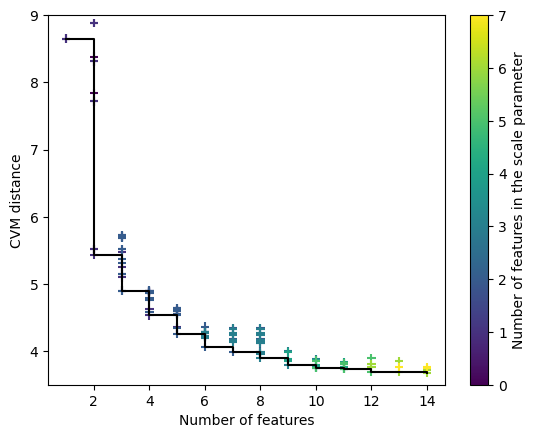

In [385]:
os.chdir(path + 'output/loss12_finale')
liste_df = []
for name_file in os.listdir():
    if name_file[0] == 'l':
        df = pd.read_csv(name_file)
        df['nbr_param'] = int(re.findall(r'\d+', name_file[10:])[0])
        liste_df.append(df)
df = pd.concat(liste_df, ignore_index = True)

# Creation of the pareto front 
pareto_front = df.groupby('nbr_param')['CVM'].min().reset_index()
pf = pareto_front.distW
for i in range(len( pf)-1):
    if  pf[i] <  pf[i+1]:
         pf[i+1] =  pf[i]


plt.step(pareto_front.nbr_param, pareto_front.distCVM, where='post', color='black')

plt.xlabel('Number of features')
plt.ylabel('CVM distance')

# Tracer la ligne noire de la frontière de Pareto

plt.colorbar(label='Number of features in the scale parameter')



plt.ylim(3.5, 9)

## Best model per iteration

In [16]:
os.chdir(path + 'output/loss12_finale')
liste_AIC = [0]*16
liste_CVM1 = [0]*16
liste_distW = [0]*16

liste_df = []
for name_file in os.listdir():
    if name_file[0] == 'l':
        df = pd.read_csv(name_file)

        index_min = df['aic'].idxmin()
        liste_AIC[int(re.findall(r'\d+', name_file[10:])[0])] = df['aic'].min()
        liste_CVM1[int(re.findall(r'\d+', name_file[10:])[0])] = df.loc[index_min, 'distCVM']
        liste_distW[int(re.findall(r'\d+', name_file[10:])[0])] = df.loc[index_min, 'distW']


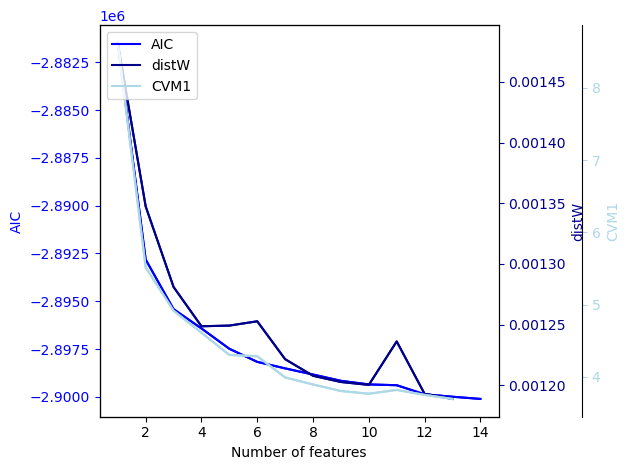

In [157]:
fig, ax1 = plt.subplots()


ax1.plot(range(1, len(liste_AIC)+1), liste_AIC, 'blue')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('AIC', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.plot(range(1, len(liste_distW)+1), liste_distW, 'darkblue')
ax2.set_ylabel('distW', color='darkblue')
ax2.tick_params('y', colors='darkblue')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # décaler le troisième axe à droite
ax3.plot(range(1, len(liste_CVM1)+1), liste_CVM1, 'lightblue')
ax3.set_ylabel('CVM1', color='lightblue')
ax3.tick_params('y', colors='lightblue')

ax1.plot(range(1, len(liste_AIC)+1), liste_AIC, label='AIC', color='blue')
ax2.plot(range(1, len(liste_distW)+1), liste_distW, label='distW', color='darkblue')
ax3.plot(range(1, len(liste_CVM1)+1), liste_CVM1, label='CVM1', color='lightblue')

fig.tight_layout()  

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.show()


# 2- CVM Error 

## Over the domain 

In [23]:
def loss(loc_pred, scale_pred, shape_pred, loc_true, scale_true, shape_true):
    n = 1000
    sample = sorted(genextreme.rvs(-shape_true, loc=loc_true, scale=scale_true, size=n))
    rangee = np.array(range(1, n+1))
    loss = (1/(12*n)) + np.sum((((2 * rangee - 1) / (2*n)) -  genextreme.cdf(sample, c = -shape_pred, scale = scale_pred, loc = loc_pred))**2)
    return loss


In [25]:
os.chdir(path)
dataf = pd.read_csv('data/data2_12.csv')
dataf = pd.merge(dataf, pd.read_csv('data/True_Parameters/gev2_param_true_present.csv'), how = 'left', on = ['rlat', 'rlon'])
dataf = dataf[['lon', 'lat', 'loc', 'loc1', 'alt', 'scale', 'shape', 'scale1', 'shape1', 'alt_mean20', 'alt_std20', 'rlat', 'rlon', 'Test', 'Val']]
dataf.drop_duplicates(inplace = True)
dataf = pd.merge(dataf, pd.read_csv('output/result_present_12.csv')[['rlat', 'rlon', 'loc_pred', 'scale_pred', 'shape_pred']], how = 'left', on = ['rlat', 'rlon'])
dataf.drop_duplicates(inplace = True)

data = dataf.copy()
data = pd.merge(data, pd.read_csv('output/indices_dry_zones.csv'), on = ['rlat', 'rlon'], how = 'left')
#data = data.loc[data.sv != 0]
data = data.loc[data.scale.isna() == False]

for index, row in tqdm.tqdm(data.iterrows()):
    loss0 = loss(row['loc_pred'], row['scale_pred'], row['shape_pred'],
                        row['loc'], row['scale'], row['shape'])
    data.loc[index, 'loss'] = loss0

15520it [00:28, 545.87it/s]


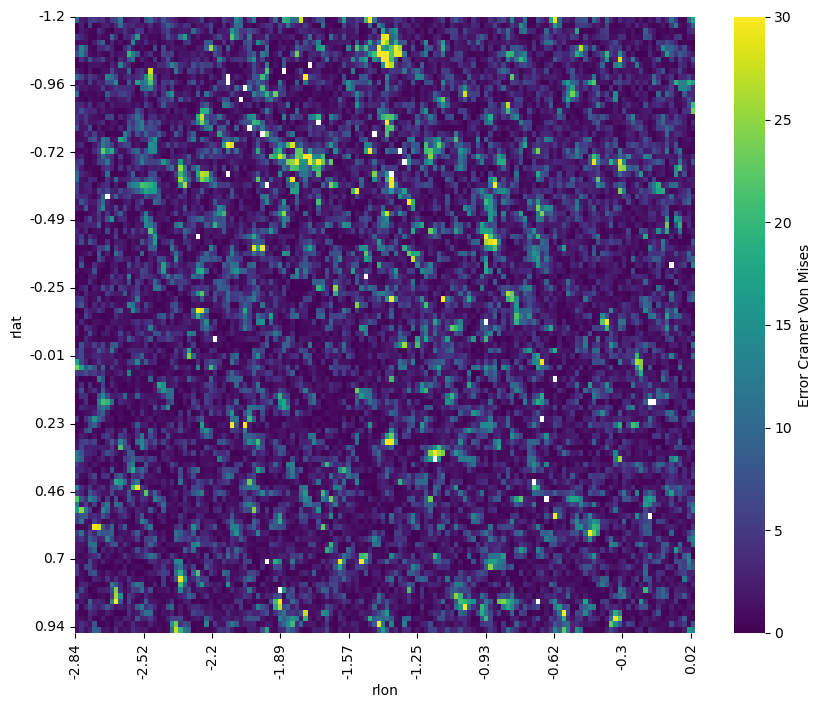

In [30]:
heatmap_data = data.pivot_table(index='rlat', columns='rlon', values='loss')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", vmin = 0, vmax = 30, cbar_kws={'label': 'Error Cramer Von Mises'})

num_labels = 10
# Afficher la heatmap
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()

## Boxplots

In [33]:
os.chdir(path)
dataf = pd.read_csv('data2_12.csv')
dataf = pd.merge(dataf, pd.read_csv('data/True_Parameters/gev2_param_true_present.csv'), how = 'left', on = ['rlat', 'rlon'])
dataf = dataf[['lon', 'lat', 'loc', 'loc1', 'alt', 'scale', 'shape', 'scale1', 'shape1', 'alt_mean20', 'alt_std20', 'rlat', 'rlon', 'Test', 'Val']]
dataf.drop_duplicates(inplace = True)
dataf = pd.merge(dataf, pd.read_csv('output/result_present_12.csv')[['rlat', 'rlon', 'loc_pred', 'scale_pred', 'shape_pred']], how = 'left', on = ['rlat', 'rlon'])
dataf.drop_duplicates(inplace = True)

data = dataf.copy()
data = pd.merge(data, pd.read_csv('output/indices_dry_zones.csv'), on = ['rlat', 'rlon'], how = 'left')

for index, row in tqdm.tqdm(data.iterrows()):
    loss0 = loss(row['loc_pred'], row['scale_pred'], row['shape_pred'],
                        row['loc'], row['scale'], row['shape'])
    data.loc[index, 'loss'] = loss0 

for index, row in data.iterrows():
    loss0 = loss(row['loc1'], row['scale1'], row['shape1'],
                        row['loc'], row['scale'], row['shape'])
    data.loc[index, 'loss0'] = loss0

data12 = data.copy()
data12 = data12.loc[data12.Val == 1] # (Espace de validation correspond à l'espace test dans le rapport)

15520it [00:32, 484.85it/s]


In [35]:
os.chdir(path)
dataf = pd.read_csv('data2_12.csv')
dataf = pd.merge(dataf, pd.read_csv('data/True_Parameters/gev2_param_true_present.csv'), how = 'left', on = ['rlat', 'rlon'])
dataf = dataf[['lon', 'lat', 'loc', 'loc1', 'alt', 'scale', 'shape', 'scale1', 'shape1', 'alt_mean20', 'alt_std20', 'rlat', 'rlon', 'Test', 'Val']]
dataf.drop_duplicates(inplace = True)
dataf = pd.merge(dataf, pd.read_csv('output/results_present_wd.csv')[['rlat', 'rlon', 'loc_pred', 'scale_pred', 'shape_pred']], how = 'left', on = ['rlat', 'rlon'])
dataf.drop_duplicates(inplace = True)

data = dataf.copy()
data = pd.merge(data, pd.read_csv('output/indices_dry_zones.csv'), on = ['rlat', 'rlon'], how = 'left')


for index, row in tqdm.tqdm(data.iterrows()):
    loss0 = loss(row['loc_pred'], row['scale_pred'], row['shape_pred'],
                        row['loc'], row['scale'], row['shape'])
    data.loc[index, 'loss'] = loss0

for index, row in tqdm.tqdm(data.iterrows()):
    loss0 = loss(row['loc1'], row['scale1'], row['shape1'],
                        row['loc'], row['scale'], row['shape'])
    data.loc[index, 'loss0'] = loss0

datawd = data.copy()
datawd = datawd.loc[datawd.Val == 1] # (Espace de validation correspond à l'espace test dans le rapport)

15520it [00:20, 771.28it/s]
15520it [00:25, 599.62it/s]


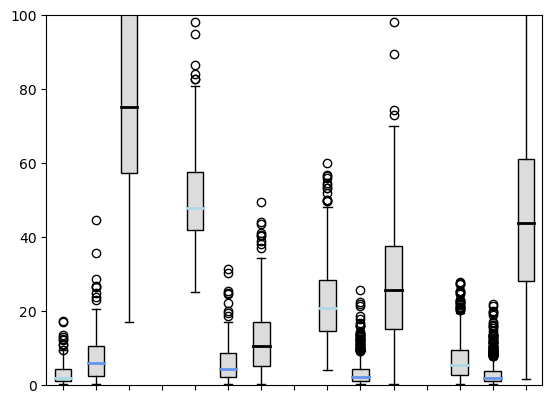

In [36]:
fig, ax = plt.subplots()
meann = np.mean(data['loc'])

# Boxplot data
box_data = [
    datawd.loc[datawd.sv == 1, 'loss'], data12.loc[data12.sv == 1, 'loss'], data12.loc[data12.sv == 1, 'loss0'], [], 
    datawd.loc[datawd.sv == 0, 'loss'], data12.loc[data12.sv == 0, 'loss'], data12.loc[data12.sv == 0, 'loss0'], [], 
    datawd.loc[(datawd.sv.isna()) & (datawd['loc'] < meann), 'loss'], data12.loc[(data12.sv.isna()) & (data12['loc'] < meann), 'loss'], 
    data12.loc[(data12.sv.isna()) & (data12['loc'] < meann), 'loss0'], [],
    datawd.loc[(datawd.sv.isna()) & (datawd['loc'] > meann), 'loss'], data12.loc[(data12.sv.isna()) & (data12['loc'] > meann), 'loss'],
    data12.loc[(data12.sv.isna()) & (data12['loc'] > meann), 'loss0']
]


labels = ['']*len(box_data)

bp = ax.boxplot(box_data, labels=labels, patch_artist=True)

colors = ['gainsboro']*len(labels)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ind = 0
for median in bp['medians']:
    if ind in [0, 4, 8, 12]: median.set(color='lightblue', linewidth=2)
    elif ind in [1, 5, 9, 13]: median.set(color='cornflowerblue', linewidth=2)
    else : median.set(color='black', linewidth=2)
    ind = ind + 1

plt.ylim(0, 100)
plt.show()


Several boxplots were explored: present vs future, present 12 vs present 24, ... all were constructed on this basis.

## Maps Parameter

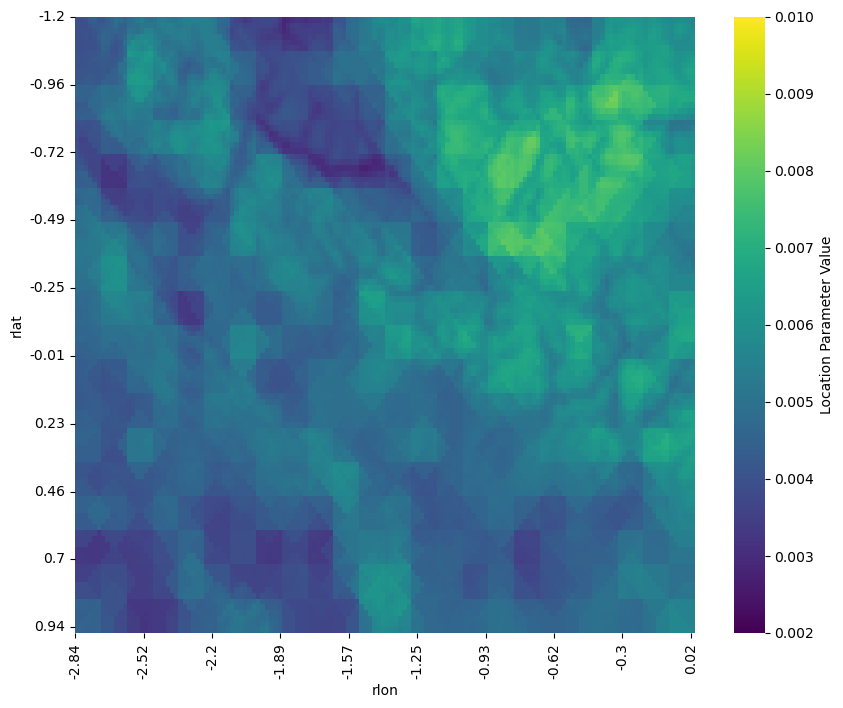

In [39]:
df = pd.read_csv('output/result_present_12.csv')

heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='loc_pred')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f", vmin = 0.002, vmax = 0.01, cbar_kws={'label': 'Location Parameter Value'})

num_labels = 10

plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()

## Maps Error

In [339]:
os.chdir(path)
df = pd.read_csv('data/dataf2_12.csv') # data future
df['loc_se'] = pd.read_csv('output/results_future_se_fit.csv')['location']
df['scale_se'] = pd.read_csv('output/results_future_se_fit.csv')['scale']
df['shape_se'] = pd.read_csv('output/results_future_se_fit.csv')['shape']

df = df[['loc_se', 'scale_se', 'shape_se', 'rlat', 'rlon']]

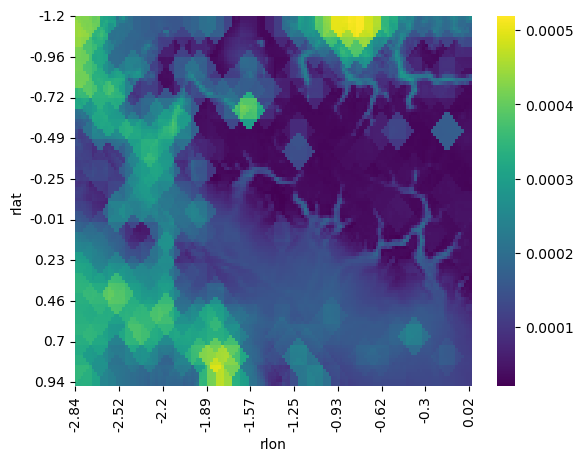

In [349]:
heatmap_data = df.pivot_table(index='rlat', columns='rlon', values='loc_se')
sns.heatmap(heatmap_data, cmap='viridis', fmt=".2f")

num_labels = 10
# Afficher la heatmap
plt.xticks(ticks=np.linspace(0, len(heatmap_data.columns) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.columns.min(), heatmap_data.columns.max(), num_labels), 2))
plt.yticks(ticks=np.linspace(0, len(heatmap_data.index) - 1, num_labels), labels=np.round(np.linspace(heatmap_data.index.min(), heatmap_data.index.max(), num_labels), 2))
plt.show()

## Distribution example

In [41]:
os.chdir(path)
df = pd.merge(pd.read_csv('result_present_12.csv'), 
            pd.read_csv('data/True_Parameters/gev2_param_true_present.csv'), 
            on = ['rlat', 'rlon'], how = 'left')

df = df[['rlat', 'rlon', 'loc', 'scale', 'shape', 'loc_pred', 'scale_pred', 'shape_pred', 'shape_bi', 'shape_bs']]
df.drop_duplicates(inplace = True)
df = pd.merge(df, pd.read_csv('data/data2_12.csv')[['rlon', 'rlat', 'Test', 'Val', 'loc1', 'scale1', 'shape1']], 
on = ['rlat', 'rlon'], how = 'left')
df = pd.merge(df, pd.read_csv('data/Topography/grille2_12.csv')[['rlon', 'rlat', 'block']], on = ['rlat', 'rlon'], how = 'left')
df.drop_duplicates(inplace = True)
#df = df.loc[df.Val == 1]
df['CVM'] = 0
df = df.loc[df.scale.isna() == False]

for index, row in tqdm.tqdm(df.iterrows()):
    df.loc[index, 'CVM'] = loss(row['loc_pred'], row['scale_pred'], row['shape_pred'], row['loc'], row['scale'], row['shape'])

15520it [00:24, 623.04it/s]


In [390]:
df_mean = df.groupby(['block']).mean(['CVM'])

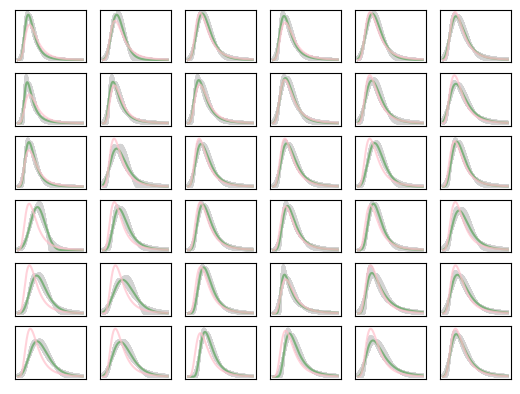

In [42]:
block = 36 #df.loc[df.CVM == np.min(df.CVM), 'block'].iloc[0]
data_local = df.loc[df.block == block]
liste_lat = sorted(list(data_local.rlat.unique()))
liste_lat = liste_lat[::-1]
liste_lon = sorted(list(data_local.rlon.unique()))
x = np.linspace(0, 0.03, 1000)

fig, axs = plt.subplots(6, 6)

for i in range(len(liste_lat)):
    for j in range(len(liste_lon)):
        rlat = liste_lat[i]
        rlon = liste_lon[j]

        data_local = df.loc[(df.rlat == rlat) & (df.rlon == rlon)]

        loc, scale, shape = list(data_local['loc'])[0], list(data_local.scale)[0], list(data_local['shape'])[0]
        shape_bi, shape_bs = list(data_local['shape_bi'])[0], list(data_local['shape_bs'])[0]
        loc_pred, scale_pred, shape_pred = list(data_local['loc_pred'])[0], list(data_local['scale_pred'])[0], list(data_local['shape_pred'])[0]


        if np.isnan(shape_bi) == False :
            for shapy in np.arange(shape_bi, shape_bs+0.001, 0.001):
                valuebi = genextreme.pdf(x, -shapy, loc=loc, scale=scale)
                axs[i, j].plot(x, valuebi, 'lightgray', alpha = 0.5)
        
        value = genextreme.pdf(x, -shape, loc=loc, scale=scale)
        value2 = genextreme.pdf(x, -shape_pred, loc=loc_pred, scale=scale_pred)
        axs[i, j].plot(x, value, label = 'True', color = 'green', alpha = 0.4)
        axs[i, j].plot(x, value2, label = 'pred', color = 'pink', alpha = 0.7)


for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])


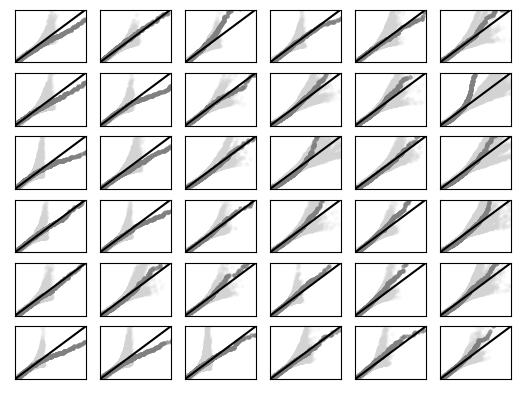

In [ ]:
#block = df.loc[df.CVM == np.max(df.CVM), 'block'].iloc[0]
data_local = df.loc[df.block == block]
liste_lat = sorted(list(data_local.rlat.unique()))
liste_lat = liste_lat[::-1]
liste_lon = sorted(list(data_local.rlon.unique()))

fig, axs = plt.subplots(6, 6)

for i in range(len(liste_lat)):
    for j in range(len(liste_lon)):
        rlat = liste_lat[i]
        rlon = liste_lon[j]

        data_local = df.loc[(df.rlat == rlat) & (df.rlon == rlon)]

        if np.isnan(list(data_local['loc'])[0]) == False :

            loc, scale, shape = list(data_local['loc'])[0], list(data_local.scale)[0], list(data_local['shape'])[0]
            shape_bi, shape_bs = list(data_local['shape_bi'])[0], list(data_local['shape_bs'])[0]
            loc_pred, scale_pred, shape_pred = list(data_local['loc_pred'])[0], list(data_local['scale_pred'])[0], list(data_local['shape_pred'])[0]

            if np.isnan(shape_bi) == False : 
                for _ in range(30):
                    shapy = random.uniform(shape_bi, shape_bs)
                    value = sorted(genextreme.rvs(size = 1000, c = shape, loc=loc, scale=scale))
                    value2 = sorted(genextreme.rvs(size = 1000, c = shapy, loc=loc, scale=scale))
                    axs[i, j].scatter(value, value2, label = 'True', color = 'lightgrey', alpha = 0.1, s=5)


            value = sorted(genextreme.rvs(size = 1000, c = -shape, loc=loc, scale=scale))
            value2 = sorted(genextreme.rvs(size = 1000, c = -shape_pred, loc=loc_pred, scale=scale_pred))
            axs[i, j].scatter(value, value2, label = 'True', color = 'grey', alpha = 0.6, s=5)
            axs[i, j].plot(np.linspace(0, 0.03, 10), np.linspace(0, 0.03, 10), label = 'True', color = 'black', alpha = 1)

        
for ax in axs.flatten():
    ax.set_xlim(0, 0.03)
    ax.set_ylim(0, 0.03)
    ax.set_xticks([])
    ax.set_yticks([])

## Exploration

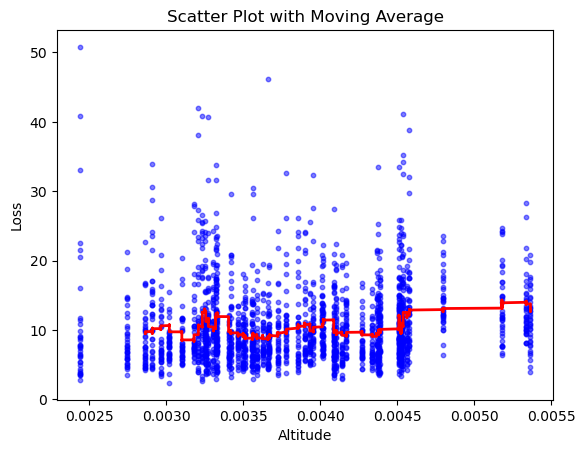

In [301]:
plt.scatter(data['loc1'], data['loss'], color='blue', alpha=0.5, s=10)

# Moving average
window_size = 100

data = data.sort_values(by='loc1')
data['moving_avg'] = data['loss'].rolling(window=window_size).mean()

plt.plot(sorted(data['loc1']), data['moving_avg'], color='red', linewidth=2)
plt.xlabel('Altitude')
plt.ylabel('Loss')
plt.title('Scatter Plot with Moving Average')
#plt.ylim(5, 35)
plt.show()

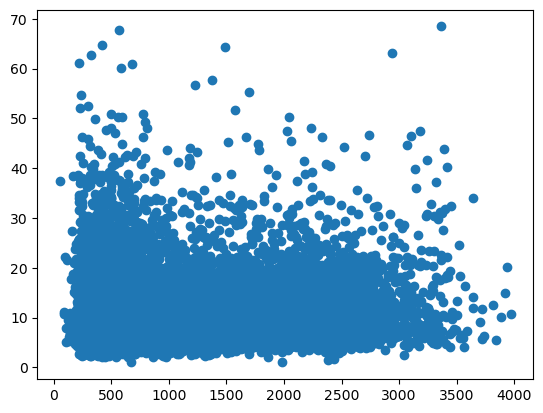

In [278]:
plt.scatter(data.alt, data.loss)
